In [19]:
import numpy  as np
import matplotlib.pyplot as plt

from utils import *

from hcipy import *

from processing import *

from astropy.io import fits

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the FITS file

In [63]:
name = "Noisy_Rolling_Shutter_Simulation_Prime_BSI"
path_name = "Rolling Shutter Simulations\\" + name + ".fits"
fits_file = fits.open(path_name)


In [64]:
fits_file[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TITLE   = 'Noisy_Rolling_Shutter_Simulation_Prime_BSI_2.fits'                   
AUTHOR  = 'Written by Kyle Lam.'                                                
FPS     = '173 # Readout speed of the detector in fps'                          
DETSIZE = '512 # Width of shortest side of detector.'                           
NSUBDIVI= '24 # Number of Subdivisions'                                         
Q       = '2 # Number of pixels per resolution element'                         
NAIRY   = '200 # The spatial extent of the grid radius in resolution elements'  
EXPOTIME= '0.01 # Exposure time in seconds'                                     
NUMEXPOS= '100 # Total Numbe

### Combine Image Data

In [65]:
npix = int(np.sqrt(np.prod(fits_file[1].data.shape)))
ims_out = []

for i in range(1, len(fits_file)):
    im = fits_file[i].data
    im_out = im.copy().reshape([npix,npix])
    ims_out.append(np.array(im_out))
ims_out_a = np.array(ims_out)

### Grabbing Values from Header Data

In [66]:
wavelength = fits_file[0].header['Wavelnth']
wavelength = wavelength.split(' ')
wavelength = float(wavelength[0])
pupil_diameter = fits_file[0].header['PUPDIAMT']
pupil_diameter = pupil_diameter.split(' ')
pupil_diameter = float(pupil_diameter[0])
mag = fits_file[0].header['PRIMAG']
mag = mag.split(' ')
mag = float(mag[0])


### Image Processing
includes preprocessing, taking FTs, power spectra, and ACFs

In [67]:
# Function Parameters - see processing.py for more detail
# ims           - input image array
# ims_ft        - input FT array
# gsigma        - std deviation for the Gaussian kernel
# subframe_size - final image size in pixels
# HWHM          - half-wavelength at half maximum for supergaussian window
# m             - order of supergaussian window
# scaling       - determines radial cutoff (fcut) for PS

ims_p = image_preprocessing(ims_out_a, 10, 550)
#              parameters: (ims, gsigma, subframe_size)

FT = fourier_transform(ims_p, 100, 4)
#              parameters: (ims, HWHM, m)

PS = power_spectrum(FT, wavelength, pupil_diameter, 1.)
#              parameters: (ims_ft, wavelength, pupil_diameter, scaling, HWHM, m)

ACF = generate_ACF(PS)
#              parameters: (ims_ps)

Text(0, 0.5, 'Mean')

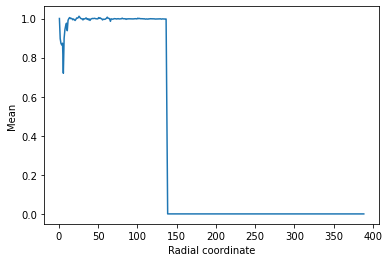

In [68]:
from radial_profile import radial_data

rad_stats = radial_data(PS[0])
plt.figure()
plt.plot(rad_stats.r, rad_stats.mean)
plt.xlabel('Radial coordinate')
plt.ylabel('Mean')

### Final Image, PS, and ACF

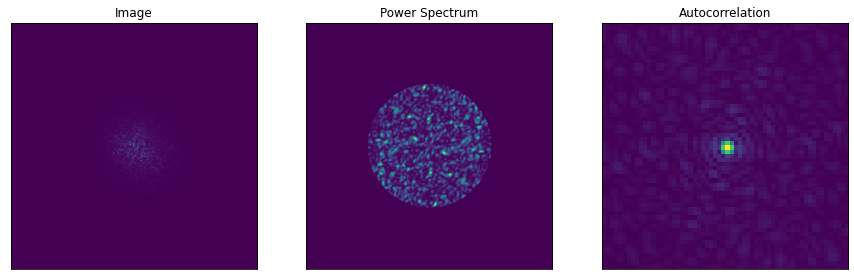

In [69]:
# Image, PS, and ACF plots
f = plt.figure(figsize=(15,5))
ax=f.add_subplot(131)
plt.imshow(ims_p[0])
ax.set_yticks([])
ax.set_xticks([])
plt.title('Image')

ax = f.add_subplot(132)
plt.title('Power Spectrum')
plt.imshow(np.abs(PS[0]))
ax.set_yticks([])
ax.set_xticks([])

fsub = 30
ax=f.add_subplot(133)
plt.imshow(np.abs(ACF[0])[int(550/2)-fsub:int(550/2)+fsub,int(550/2)-fsub:int(550/2)+fsub])
ax.set_yticks([])
ax.set_xticks([])
plt.title('Autocorrelation')
plt.show()

# To save image:
#plt.savefig('speckle_imaging.png')

## Speckle Contrast Curve

In [70]:
# Grid: 800 pixels across, equalling 200 lambda / D, plate scale is then 0.25*lambda / D per pixel
plate_scale = 0.25 * wavelength / pupil_diameter * 206265.   #of image in (arcsec / pixel)

# Plate scale in meters per pixel
ps_mpp = 1. / (npix * plate_scale) * 206265. * wavelength 
scaling = 0.5
fcut = pupil_diameter / ps_mpp * scaling

C:\Users\User\Documents\Academic\Git\specklepol\processing.py:182: RuntimeWarning: invalid value encountered in sqrt
  ACF_ccs_out = -2.5*np.log10((1.-np.sqrt(1.-(2*ACF)**2))/(2*ACF))


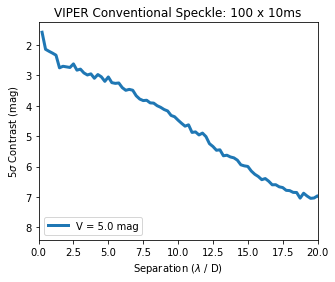

In [71]:
#Generating contrast curves

ACF_m = ACF_cc(ACF[0])
rad_ACF = radial_data(np.abs(ACF[0]), annulus_width=2)
cc = ACF_cc(5*rad_ACF.std)
xax = np.array(range(len(rad_ACF.mean))) * plate_scale / ((wavelength) / pupil_diameter * 206265) #in lambda/D units

f = plt.figure(figsize=(5,4))
plt.plot(xax,cc,label='V = '+str(mag)+' mag',lw=3)
plt.xlim(0.0,20.0)
plt.gca().invert_yaxis()
plt.legend(loc='lower left')
plt.ylabel(r'5$\sigma$ Contrast (mag)')
plt.xlabel(r'Separation ($\lambda$ / D)')
plt.title('VIPER Conventional Speckle: 100 x 10ms')
#plt.savefig('speckle_cont_conv_2.png',dpi=300)
plt.show()